<div align="center">
  <h1><b>Penyisihan Datavidia 9</b></h1>
  <p><b>Supercalifragilisticexpialidocious</b></p>
  <span style="font-size: 12px;">Author: <a href="https://github.com/ChristellaCindy">Christella Cindy</a>, <a href="https://github.com/Frederickkrisna">Frederick Krisna</a>, and <a href="https://github.com/williamtheodoruswijaya">William Theodorus</a></span>
</div>
<hr>

### 1. Import Libraries

In [56]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

- `Evaluation`

In [57]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    float: The calculated MAPE.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 2. Load Dataset
---
untuk training, kita akan coba pakai salah terlebih dahulu yaitu "Bawang Merah"

In [58]:
path = "/Users/Hendra Wijaya/OneDrive/Documents/Binus/Datavidia/penyisihan-datavidia/comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan"
files = [
    "Bawang Merah", "Bawang Putih Bonggol", "Beras Medium", "Beras Premium",
    "Cabai Merah Keriting", "Cabai Rawit Merah", "Daging Ayam Ras",
    "Daging Sapi Murni", "Gula Konsumsi", "Minyak Goreng Curah",
    "Minyak Goreng Kemasan Sederhana", "Telur Ayam Ras", "Tepung Terigu (Curah)"
]

# Load data
df_list = {}
for file in files:
    df = pd.read_csv(f"{path}/train/{file}.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df_list[file] = df

# For Training purpose, we use only Bawang Merah since all training have the same approach
df = df_list["Bawang Merah"]
df.head()

,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,28970.0,20870.0,26890.0,26650.0,25240.0,35510.0,31740.0,23390.0,25800.0,24870.0,...,48610.0,29240.0,25160.0,24910.0,28030.0,30380.0,35750.0,23360.0,26670.0,28710.0
2022-01-02,29900.0,20710.0,25600.0,26950.0,25240.0,31850.0,30020.0,23550.0,26010.0,24630.0,...,50160.0,28750.0,24770.0,24360.0,27200.0,30260.0,35630.0,23790.0,25690.0,28460.0
2022-01-03,28970.0,20510.0,26390.0,27290.0,24620.0,34880.0,31250.0,23730.0,25910.0,24810.0,...,49510.0,27870.0,24140.0,24740.0,26750.0,30080.0,34980.0,22620.0,26270.0,28050.0
2022-01-04,29600.0,20180.0,26630.0,27450.0,24370.0,35260.0,31640.0,23300.0,25950.0,24910.0,...,49670.0,28330.0,24450.0,24710.0,28800.0,29950.0,34920.0,23010.0,26800.0,27800.0
2022-01-05,29540.0,19960.0,26610.0,27710.0,24210.0,35260.0,34010.0,23640.0,25700.0,24580.0,...,46590.0,28240.0,24640.0,24780.0,28990.0,30240.0,34000.0,23330.0,25360.0,27670.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2022-01-01 to 2024-09-30
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Aceh                       967 non-null    float64
 1   Bali                       968 non-null    float64
 2   Banten                     967 non-null    float64
 3   Bengkulu                   967 non-null    float64
 4   DI Yogyakarta              968 non-null    float64
 5   DKI Jakarta                967 non-null    float64
 6   Gorontalo                  969 non-null    float64
 7   Jambi                      966 non-null    float64
 8   Jawa Barat                 967 non-null    float64
 9   Jawa Tengah                970 non-null    float64
 10  Jawa Timur                 969 non-null    float64
 11  Kalimantan Barat           968 non-null    float64
 12  Kalimantan Selatan         967 non-null    float64
 13  Kalimantan Tengah          968

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Aceh,967.0,34740.020683,7681.229521,21860.0,30555.0,33790.0,36660.0,61030.0
Bali,968.0,28202.200413,6421.992994,14810.0,24215.0,28150.0,30935.0,53400.0
Banten,967.0,34011.065150,7649.079784,21460.0,29625.0,32770.0,37285.0,68970.0
Bengkulu,967.0,34812.130300,7773.763022,19520.0,30915.0,34370.0,37750.0,61590.0
DI Yogyakarta,968.0,30753.657025,7927.974207,16200.0,25755.0,30185.0,35450.0,61470.0
DKI Jakarta,967.0,41475.170631,8408.909831,26580.0,36915.0,40500.0,44300.0,74630.0
Gorontalo,969.0,38127.925697,8728.726011,21250.0,33330.0,37640.0,42930.0,78300.0
Jambi,966.0,28944.668737,6416.316381,17180.0,25475.0,28355.0,31412.5,48820.0
Jawa Barat,967.0,33151.437435,7004.698549,22000.0,28985.0,31860.0,37020.0,65350.0
Jawa Tengah,970.0,32025.659794,7615.586946,19340.0,26960.0,30855.0,36037.5,64100.0


### 3. Exploratory Data Analysis

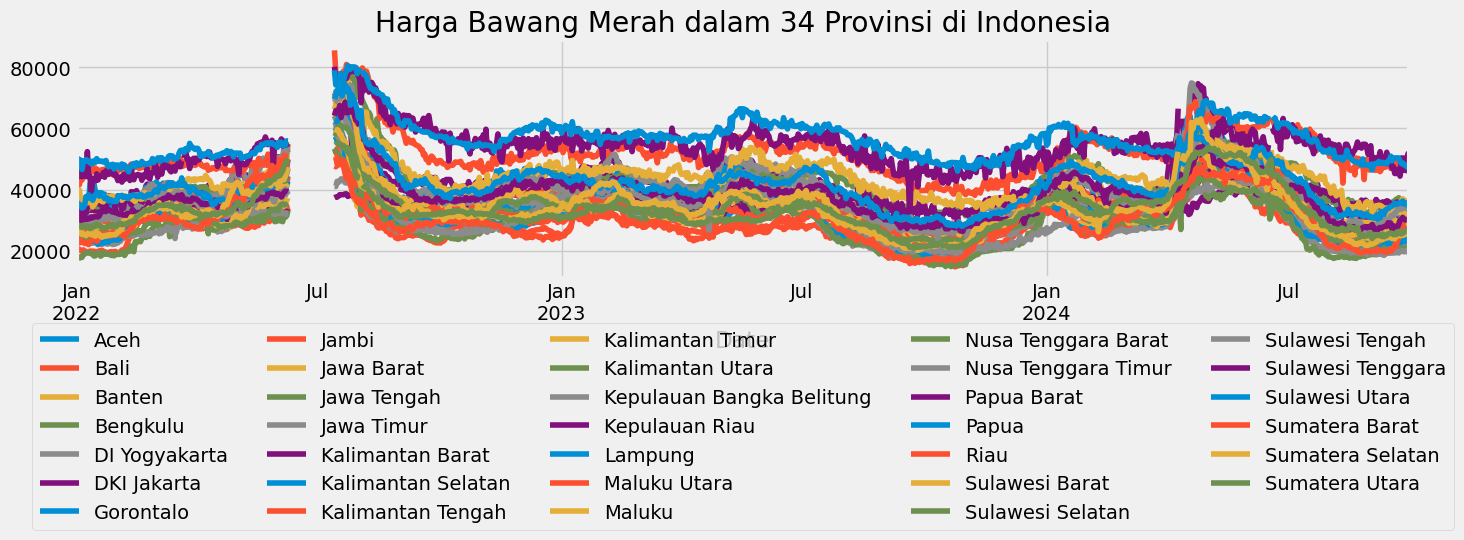

In [61]:
df.plot(figsize=(15, 6))
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

**Insight:**

Berdasarkan visualisasi yang kita lihat, harga bawang merah memiliki missing data pada Juli 2023. Sehingga kita akan coba melakukan sedikit pendekatan dengan melakukan interpolasi data untuk mengisi kekosongan data ini.

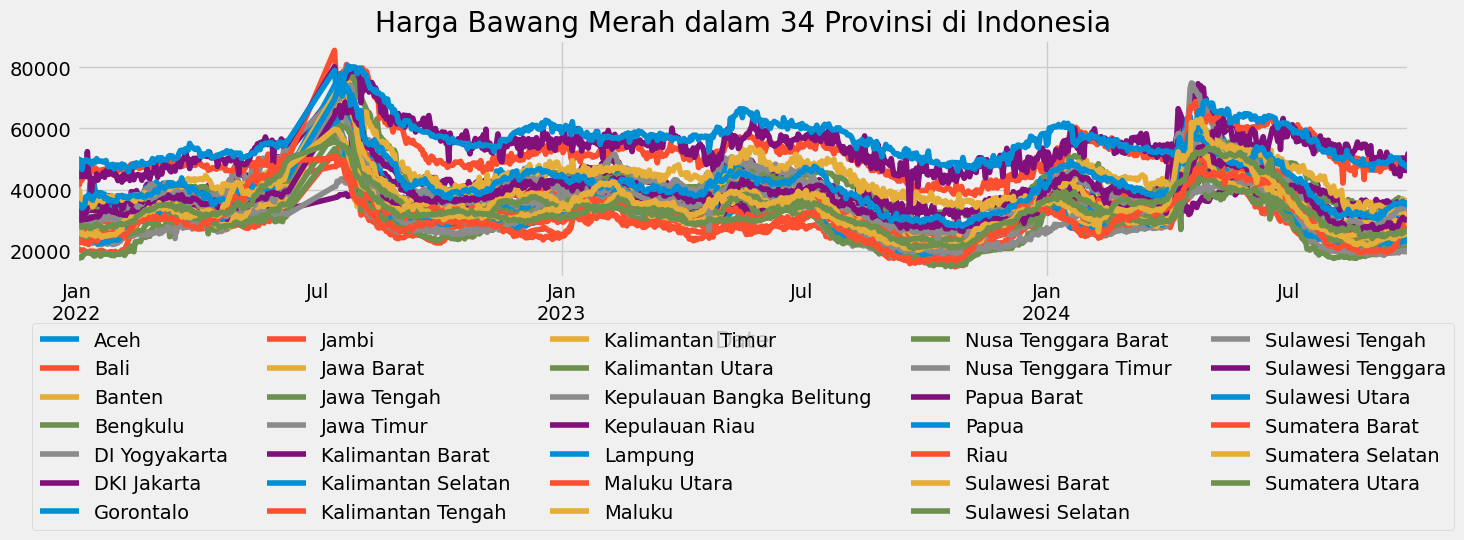

In [62]:
df.interpolate(method='linear', inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True)
df.plot(figsize=(15, 6))
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

Sekarang, coba kita rapikan visualisasinya dengan memperkecil range tanggal kita. Misal, dalam tahun waktu seminggu, kira-kira bagaimana fluktuasi harga bahan pangannya.

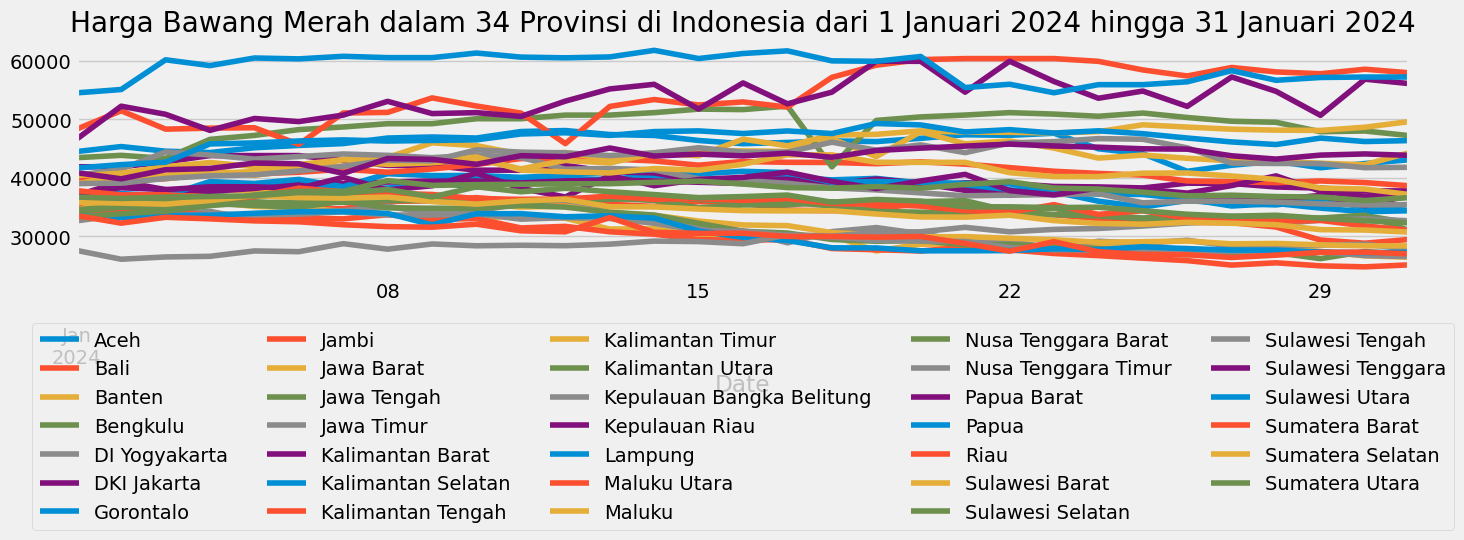

In [63]:
df_2024 = df[(df.index >= '2024-01-01') & (df.index <= '2024-01-31')]
df_2024.plot(figsize=(15, 6), lw = 4)
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia dari 1 Januari 2024 hingga 31 Januari 2024')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

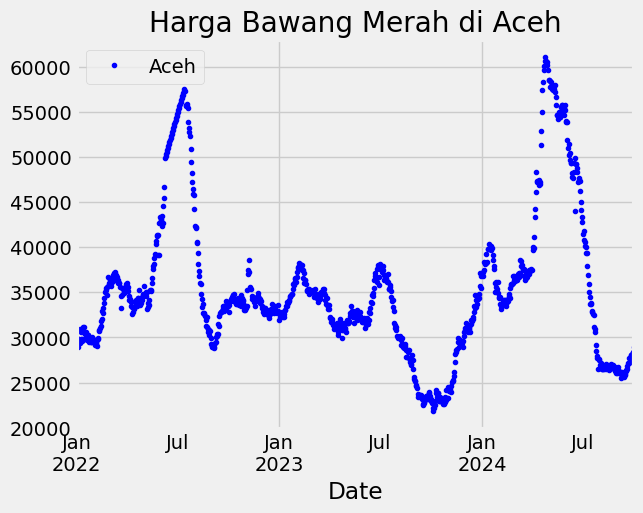

In [64]:
# Take 'Aceh' data only for training only
df_aceh = df[['Aceh']]

plt.figure(figsize=(15, 6))
df_aceh.plot(style='.', 
             color='blue', 
             title='Harga Bawang Merah di Aceh')
plt.show()

### 4. Data Preprocessing

> Outlier Removal

In [65]:
def clean_and_interpolate(df, column):
    """
    Membersihkan data dengan menghapus outlier dan menginterpolasi nilai kosong.
    """
    z_scores = np.abs(stats.zscore(df[column]))
    df[column] = pd.Series(np.where(z_scores > 3, np.nan, df[column]), index=df.index)
    df[column] = df[column].interpolate(method='linear').bfill().ffill()
    return df

> Stationary Check

In [66]:
def check_stationarity(df, column):
    """
    Melakukan uji ADF untuk mengecek stationary data.
    """
    adf_result = adfuller(df[column])
    p_value = adf_result[1]
    
    if p_value > 0.05:
        print(f'Data {column} non-stationary (p={p_value:.3f}), differencing diperlukan!')
        return False
    else:
        print(f'Data {column} sudah stationary (p={p_value:.3f}).')
        return True

> Melakukan differencing jika `check_stationarity(df, column)` = True

In [82]:
def difference(df, column):
    """
    Melakukan differencing pada data.
    """
    df[column] = df[column].diff()
    return df

> Melakukan uji seasonality

- **Apply preprocessing to our data:**

In [68]:
df_aceh = clean_and_interpolate(df_aceh, 'Aceh')
is_stationary = check_stationarity(df_aceh, 'Aceh')

Data Aceh sudah stationary (p=0.008).


### 4. Train/Test Split

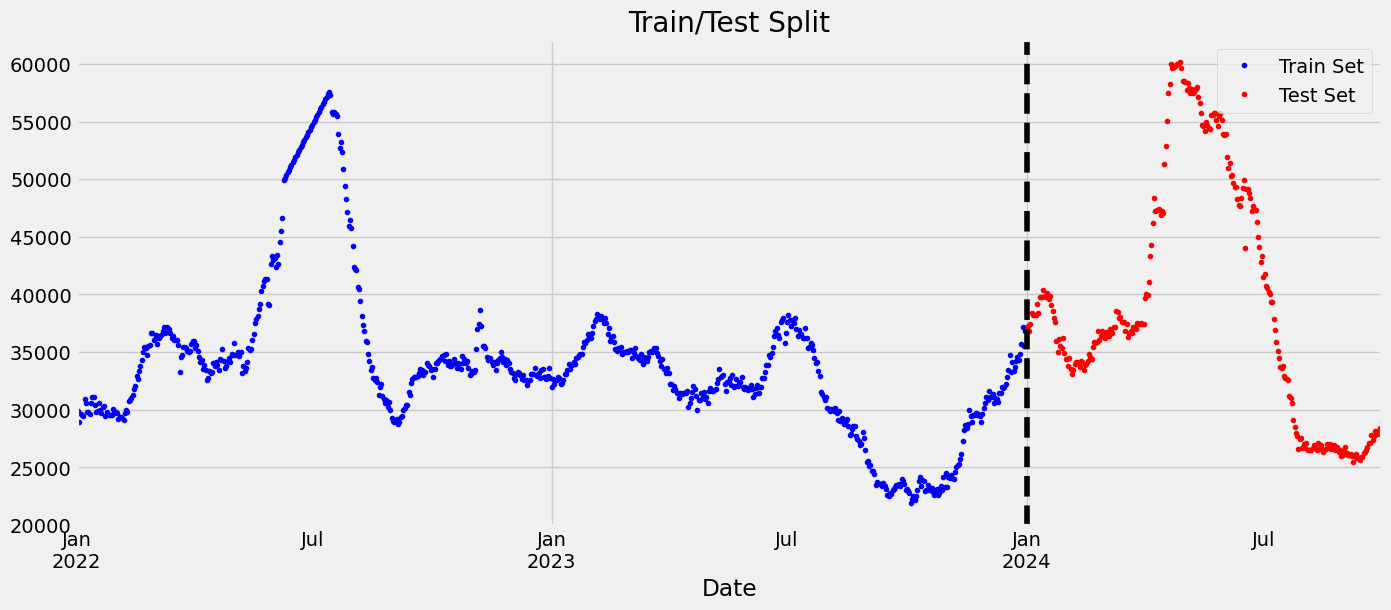

In [69]:
train_aceh = df_aceh.loc[df.index < '2024-01-01']
test_aceh = df_aceh.loc[df.index >= '2024-01-01']

fig, ax = plt.subplots(figsize=(15, 6))
train_aceh.plot(ax=ax, color='blue', style='.', lw=2)
test_aceh.plot(ax=ax, color='red', style='.', lw=2)
plt.title('Train/Test Split')
ax.axvline('01-01-2024', color='black', linestyle='--')
ax.legend(['Train Set', 'Test Set'])
plt.show()

### 6. Modelling

- 6.1 Data Splitting

In [70]:
train_aceh = df_aceh.loc[df_aceh.index < '2024-01-01']
test_aceh = df_aceh.loc[df_aceh.index >= '2024-01-01']

- 6.2 Modelling

    - **Arima Model**
        - Inisialisasi model:
            - `auto_arima()`:
                - parameter pertama adalah data training yang kurang lebih adalah label yang mau kita prediksi.
                - `seasonal` adalah parameter yang bersifat boolean yang menyatakan apakah data kita itu bersifat seasonality atau tidak.
        - Training model:
            - `.fit()`: menerima data training saja (data training yang diterima adalah data label tanpa adanya fitur tambahan)
        - Attributes:
            - `.order`: memberikan best `order` yang didapatkan untuk model ARIMA

        - Methods:
            - `.predict()`: memerlukan parameter **`n_periods`** yang menyatakan berapa banyak mau prediksi ke masa depan. Dia akan return sebuah series yang berisi prediksi ke masa depan sebesar `n_periods`

In [71]:
# Generate date untuk forecast steps setelah 31 Januari 2024
forecast_steps = len(test_aceh)

# Buat sebuah DataFrame kosong dengan index tanggal yang akan di forecast
forecast_dates = pd.date_range(start='2024-01-01',  # Awal mulai forecast
                               periods=forecast_steps, # Jumlah periode forecast (hari)
                               freq='D') # Frekuensi data harian, ubah ke 'D' untuk satuan hari, 'M' untuk satuan bulan, dst...

In [72]:
# Inisialisasi model ARIMA
model_ARIMA = auto_arima(   train_aceh["Aceh"], 
                            start_p=0, start_q=0,
                            max_p=3, max_q=3,
                            seasonal=True, 
                            stationary=is_stationary,
                            m = 7,
                            stepwise=True, 
                            suppress_warnings=True,
                            error_action='ignore', 
                            trace=True)

forecast_ARIMA = model_ARIMA.predict(n_periods=forecast_steps)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=14121.832, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14957.878, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13438.473, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17334.896, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=14038.596, Time=0.23 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=14321.423, Time=1.39 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=13022.099, Time=1.31 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=14285.938, Time=1.48 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=13649.286, Time=0.72 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=11389.933, Time=0.36 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=11402.549, Time=0.27 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=11387.736, Time=1.71 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=11388.911, Time=1.16 sec
 ARIMA(1,0,1)(2,0,2)[7] i

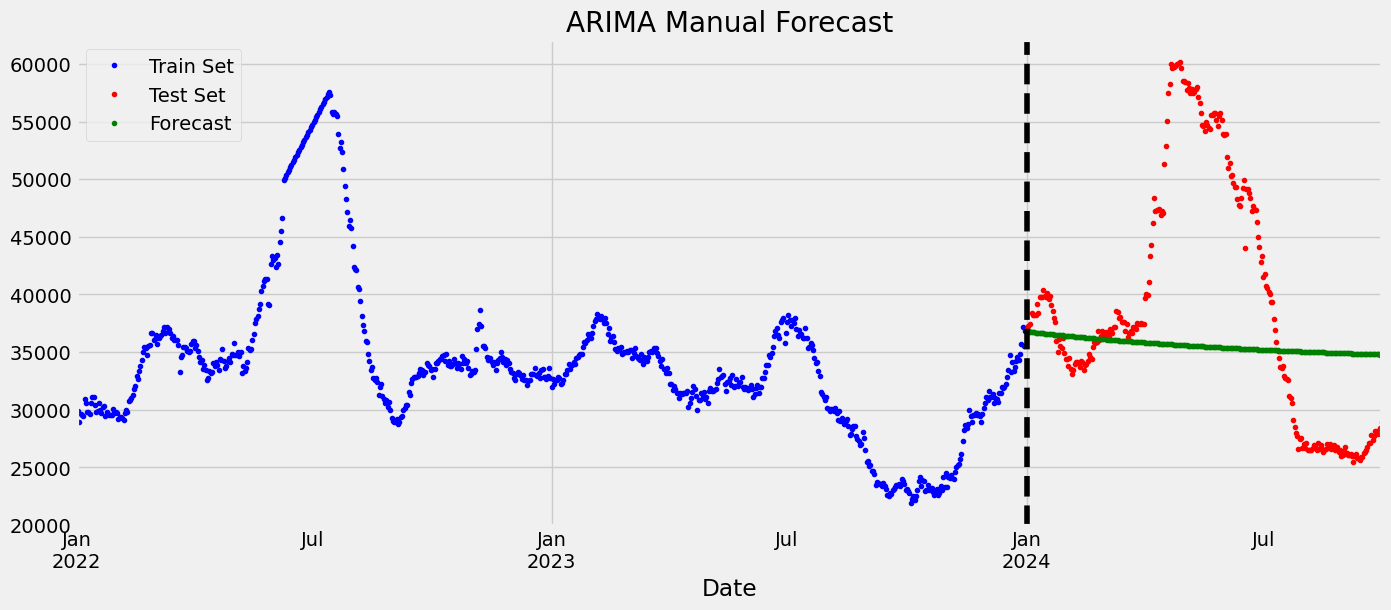

In [73]:
model_ARIMA_manual = ARIMA(train_aceh["Aceh"], order=model_ARIMA.order)
model_ARIMA_manual_fit = model_ARIMA_manual.fit()

forecast_ARIMA_manual = model_ARIMA_manual_fit.get_forecast(steps=forecast_steps)
forecast_ARIMA_manual = forecast_ARIMA_manual.predicted_mean

fig, ax = plt.subplots(figsize=(15, 6))
train_aceh.plot(ax=ax, color='blue', style='.', lw=2)
test_aceh.plot(ax=ax, color='red', style='.', lw=2)
forecast_ARIMA_manual.plot(ax=ax, color='green', style='.', lw=2)
plt.title('ARIMA Manual Forecast')
ax.axvline('01-01-2024', color='black', linestyle='--')
ax.legend(['Train Set', 'Test Set', 'Forecast'])
plt.show()

### 7. Evaluation

In [74]:
# Calculate MAPE
y_pred = forecast_ARIMA
y_test = test_aceh["Aceh"]

mape_ARIMA = mape(y_test, y_pred)
print(f'MAPE Score: {mape_ARIMA:.2f}%')

MAPE Score: 19.79%


In [75]:
# Calculate MAPE
y_pred_manual = forecast_ARIMA_manual
y_test = test_aceh["Aceh"]

mape_ARIMA_manual = mape(y_test, y_pred_manual)
print(f'MAPE Score Manual: {mape_ARIMA_manual:.2f}%')

MAPE Score Manual: 20.11%


**Conclusions**:
    Dari sini kita tau kalau AUTO_ARIMA bekerja sedikit lebih baik ketimbang ARIMA

---
### 8. Submissions

In [ ]:
def train_predict_auto_arima_v2(df, province, komoditas='Tepung Terigu (Curah)',
                                cutoff_date='2024-10-01',
                                forecast_steps_default=92, save_plot=False):
    df = df.copy()

    # Preprocessing (clean & interpolate + cek stasioneritas)
    df_province = df[[province]]
    df_province = clean_and_interpolate(df_province, province)
    is_stationary = check_stationarity(df_province, province)

    ts = df_province.rename(columns={province: 'Price'})

    # Train-test split
    train = ts.loc[ts.index < cutoff_date]
    test = ts.loc[ts.index >= cutoff_date]

    # Forecasting dates
    forecast_steps = forecast_steps_default
    forecast_dates = pd.date_range(start=cutoff_date, periods=forecast_steps, freq='D')

    # Auto ARIMA (biar order otomatis)
    print(f"Training auto_arima untuk {komoditas} di {province} ...")
    stepwise_model = auto_arima(
        train['Price'],
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        seasonal=False,
        stationary=is_stationary,
        m=7,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic',
        random_state=42
    )

    order = stepwise_model.order
    print(f"Best ARIMA order: {order}")

    # Build dan fit model ARIMA dari statsmodels
    model = ARIMA(train['Price'], order=order)
    model_fit = model.fit()

    # Forecast
    forecast_result = model_fit.get_forecast(steps=forecast_steps)
    forecast_mean = forecast_result.predicted_mean

    # Buat dataframe forecast untuk submission
    df_forecast = pd.DataFrame({
        'Date': forecast_dates,
        'price': forecast_mean.values
    })

    df_forecast['id'] = df_forecast['Date'].dt.strftime(f"{komoditas}/{province}/%Y-%m-%d")
    submission = df_forecast[['id', 'price']]

    # Hitung MAPE jika ada test data
    if len(test) > 0:
        test_actual = test['Price'].iloc[:forecast_steps]
        mape_val = mape(test_actual, forecast_mean)
    else:
        mape_val = None

    # Plot hasilnya
    if save_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train['Price'], label='Train', color='blue')
        plt.plot(test.index, test['Price'], label='Test', color='red')
        plt.plot(forecast_dates, forecast_mean, label='Forecast', color='green')
        plt.axvline(cutoff_date, color='black', linestyle='--')
        plt.title(f'Forecast {komoditas} di {province}')
        plt.legend()
        plt.show()

    return submission, mape_val, model_fit.summary(), order


In [99]:
all_final_submissions = []
all_mape = []
all_orders = []

for komoditas in files:
    print(f"Processing komoditas: {komoditas} ...")
    df_temp = df_list[komoditas]

    for prov in df_temp.columns.tolist():
        print(f" - Provinsi: {prov}")

        submission_prov, mape_val, model_summary, order = train_predict_auto_arima_v2(
            df_temp,
            province=prov,
            komoditas=komoditas,
            cutoff_date='2024-10-01',
            save_plot=False 
        )

        all_final_submissions.append(submission_prov)

        if mape_val is not None:
            all_mape.append({
                'Komoditas': komoditas,
                'Provinsi': prov,
                'MAPE': mape_val,
                'Order': order
            })

        print(model_summary)

# Gabungkan hasil submission
final_all_submission = pd.concat(all_final_submissions, ignore_index=True)
final_all_submission.to_csv("submission.csv", index=False)

Processing komoditas: Bawang Merah ...
 - Provinsi: Aceh
Data Aceh sudah stationary (p=0.008).
Training auto_arima untuk Bawang Merah di Aceh ...
Best ARIMA order: (2, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1004
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7926.010
Date:                Sat, 15 Mar 2025   AIC                          15864.020
Time:                        17:34:53   BIC                          15893.491
Sample:                    01-01-2022   HQIC                         15875.219
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.541e+04   2231.665    